In [15]:
using StatsPlots
using Distributions
using Turing
using StatisticalRethinking

default(label=false)

# Easy problems

* 4E1: y ~ Normal(μ, σ)
* 4E2: 2
* 4E3: $$P(\mu,\sigma|y)=\frac{\prod_i \mathcal{N}(y_i|\mu,\sigma)\mathcal{N}(\mu|0,10)Exp(\sigma|1)}
{\int\int\prod_i \mathcal{N}(y_i|\mu,\sigma)\mathcal{N}(\mu|0,10)Exp(\sigma|1)}$$
* 4E4: $$\mu_i = \alpha + \beta x_y$$
* 4E5: 3

# Medium problems

## 4M1

In [9]:
μ = rand(Normal(0, 10), 1000)
σ = rand(Exponential(1), 1000)
y = [rand(Normal(μ_v, σ_v)) for (μ_v, σ_v) ∈ zip(μ, σ)];

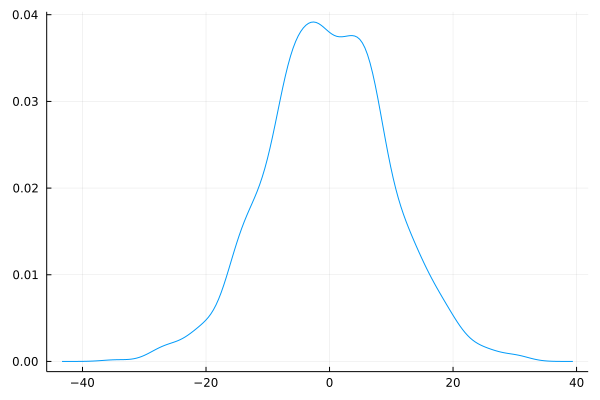

In [13]:
density(y)

## 4M2

In [17]:
@model function model_4m2(y)
    μ ~ Normal(0, 10)
    σ ~ Exponential(1)
    for i ∈ eachindex(y)
        y[i] ~ Normal(μ, σ)
    end
end

model_4m2 (generic function with 1 method)

## 4M3

```
σ ~ Exponential(1)
a ~ Uniform(0, 10)
b ~ Uniform(0, 1)
μᵢ = a + b⋅xᵢ
yᵢ ~ Normal(μ, σ)
```

## 4M4